Your Name and PRN:
- Name : Anurag Sahu
- PRN  : 250840128011
- Date : 23 Nov 2025 

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
rng=np.random.default_rng(seed=42)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
# from utils.helper import fn_plot_torch_hist,fn_plot_confusion_matrix
import tensorflow as tf

from sklearn.preprocessing import StandardScaler


In [2]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', '..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

EPOCHS=100
BATCH_SIZE=64
TEST_SIZE=0.2
TRAIN_SIZE = int(18 * BATCH_SIZE)

ALPHA = 0.001
WEIGHT_DECAY = 0.001
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE=5
MIN_LR = 1e-6

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [3]:
train_df = pd.read_csv(r"D:\dnn_input\fashion_mnist\fashion-mnist_train.csv")
test_df = pd.read_csv(r"D:\dnn_input\fashion_mnist\fashion-mnist_test.csv")

In [4]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
X_train,y_train = train_df.drop('label',axis=1),train_df['label']
X_test,y_test = test_df.drop('label',axis=1),test_df['label']

In [7]:
train_X=torch.tensor(X_train.values,dtype=torch.float32,device=device)
test_X=torch.tensor(X_test.values,dtype=torch.float32,device=device)

train_y=torch.tensor(y_train.values,dtype=torch.int64,device=device)
test_y=torch.tensor(y_test.values,dtype=torch.int64,device=device)

## Model Creation

In [8]:
class Model(nn.Module):

    def __init__(self,input_dim):
        super().__init__()
        
        dim_1 = 512
        self.layer1 = nn.Linear(input_dim,dim_1)
        self.activ1 = nn.ReLU()                 ##  output 512
        
        dim_2 = 256
        self.layer2 = nn.Linear(dim_1,dim_2)
        self.activ2 = nn.ReLU()                 ##  output 256

        dim_3 = 128
        self.layer3 = nn.Linear(dim_2,dim_3)
        self.activ3 = nn.ReLU()                 ##  output 128

        dim_4 = 64
        self.layer4 = nn.Linear(dim_3,dim_4)
        self.activ4 = nn.ReLU()                 ##  output 64

        dim_5 = 32
        self.layer5 = nn.Linear(dim_4,dim_5)
        self.activ5 = nn.ReLU()                 ##  output 32
        

        dim_6 = 18
        self.layer6 = nn.Linear(dim_5,dim_6)
        self.activ6 = nn.ReLU()                 ##  output 18 

        output_dim = 10
        self.layer7 = nn.Linear(dim_6,output_dim)  ## Output 10
        # self.activ5 = nn.LogSigmoid(dim =1)

    def forward(self,x):
        x = self.activ1(self.layer1(x))
        x = self.activ2(self.layer2(x))
        x = self.activ3(self.layer3(x))
        x = self.activ4(self.layer4(x))
        x = self.layer5(x)
        return x

model =Model(input_dim=784).to(device)

In [9]:
from torchinfo import summary


summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            401,920
├─ReLU: 1-2                              --
├─Linear: 1-3                            131,328
├─ReLU: 1-4                              --
├─Linear: 1-5                            32,896
├─ReLU: 1-6                              --
├─Linear: 1-7                            8,256
├─ReLU: 1-8                              --
├─Linear: 1-9                            2,080
├─ReLU: 1-10                             --
├─Linear: 1-11                           594
├─ReLU: 1-12                             --
├─Linear: 1-13                           190
Total params: 577,264
Trainable params: 577,264
Non-trainable params: 0

In [10]:
print(model)

Model(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (activ2): ReLU()
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (activ3): ReLU()
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (activ4): ReLU()
  (layer5): Linear(in_features=64, out_features=32, bias=True)
  (activ5): ReLU()
  (layer6): Linear(in_features=32, out_features=18, bias=True)
  (activ6): ReLU()
  (layer7): Linear(in_features=18, out_features=10, bias=True)
)


In [11]:
loss_fn=nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(),lr=0.001)

In [12]:
train_loss,test_loss=[],[]
train_acc,test_acc=[],[]
EPOCHS=100

for epoch in range(EPOCHS):
    model.train()
    outputs = model(train_X)
    loss = loss_fn(outputs,train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    _,y_pred=torch.max(outputs,1)

    curr_acc=accuracy_score(y_train,y_pred.data.cpu())
    train_acc.append(curr_acc)


    with torch.no_grad():
        model.eval()
        outputs=model(test_X)
        tloss=loss_fn(outputs,test_y)
        test_loss.append(tloss.item())
        _,y_pred = torch.max(outputs,1)

        tcurr_acc = accuracy_score(y_test,y_pred.data.cpu())
        test_acc.append(tcurr_acc)

    if epoch % 10 == 0:
        print(f"Epoch:{epoch} - Loss:{loss.item():.4f}")

Epoch:0 - Loss:4.0970
Epoch:10 - Loss:0.9313
Epoch:20 - Loss:0.6029
Epoch:30 - Loss:0.4983
Epoch:40 - Loss:0.4530
Epoch:50 - Loss:0.4155
Epoch:60 - Loss:0.3883
Epoch:70 - Loss:0.3782
Epoch:80 - Loss:0.3467
Epoch:90 - Loss:0.3359


In [13]:
result_df=pd.DataFrame(data={'loss':train_loss,"val_loss":test_loss,"accuracy":train_acc,'val_accuracy':test_acc,'epoch':range(0,EPOCHS)})

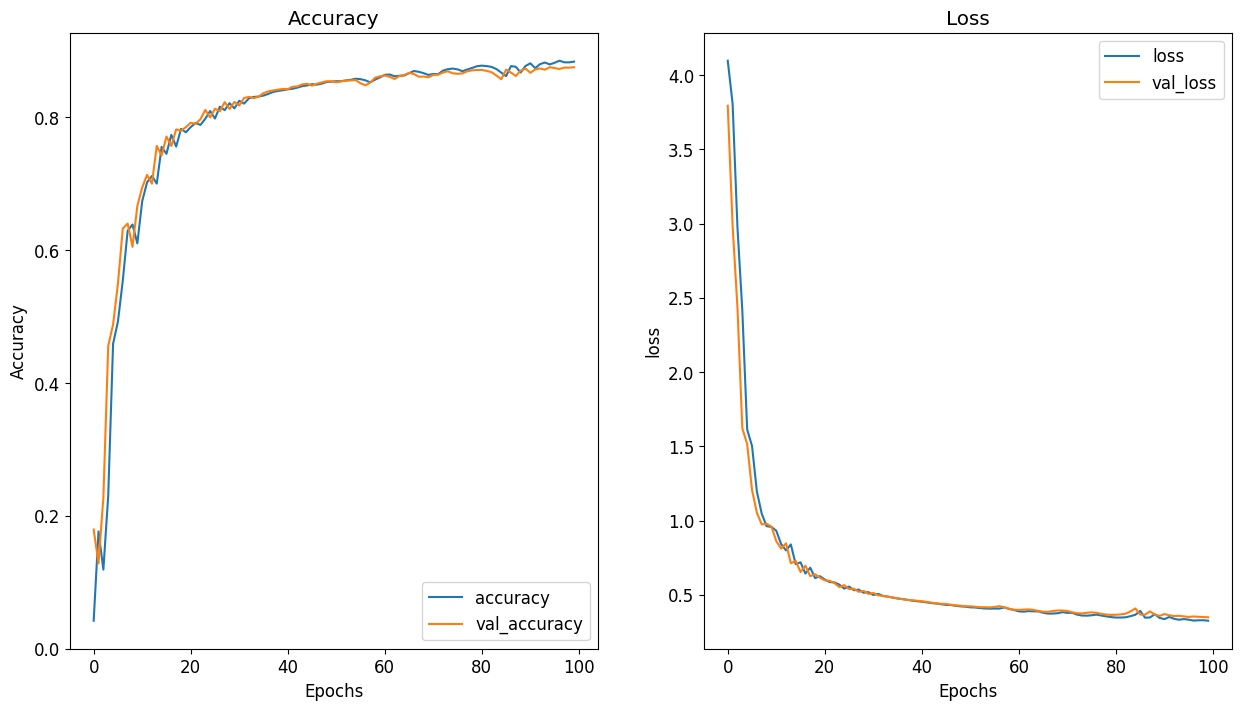

In [14]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].plot(result_df.epoch,result_df['accuracy'],label='accuracy')
ax[0].plot(result_df.epoch,result_df['val_accuracy'],label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(result_df.epoch,result_df['loss'],label='loss')
ax[1].plot(result_df.epoch,result_df['val_loss'],label='val_loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].legend()

plt.show()

In [16]:
result_df.sort_values(by = 'val_accuracy',ascending=False)

,loss,val_loss,accuracy,val_accuracy,epoch
94,0.336444,0.354365,0.879967,0.8758,94
99,0.325281,0.348390,0.884167,0.8757,99
97,0.328137,0.351619,0.883100,0.8751,97
98,0.328653,0.350047,0.883067,0.8751,98
95,0.332430,0.350631,0.882450,0.8744,95
...,...,...,...,...,...
4,1.613002,1.514140,0.459083,0.4882,4
3,2.414302,1.621178,0.230450,0.4560,3
2,2.973510,2.432682,0.118900,0.2276,2
0,4.096971,3.793769,0.041917,0.1793,0
